In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

""" DL imports """

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
#import voxelmorph as vxm
#from tensorflow.keras 


In [29]:
ct_path = "/home/jtabalon/airway_seg/test_data/ct_patients10004O.nii"
aw_path = "/home/jtabalon/airway_seg/test_data/aw_10004O.nii"

img = nib.load(ct_path).get_fdata()
mask = nib.load(aw_path).get_fdata()

test_img = np.expand_dims(np.expand_dims(img, -1), 0)
test_mask = np.expand_dims(np.expand_dims(mask, -1), 0)


print(img.shape, mask.shape, type(img), type(mask))

# Visualize CT

#plt.imshow(img[:, :, 100], cmap = "gray")
#plt.show()

(512, 512, 662) (512, 512, 662) <class 'numpy.memmap'> <class 'numpy.memmap'>


In [30]:
print(test_img.shape, test_mask.shape)

(1, 512, 512, 662, 1) (1, 512, 512, 662, 1)


In [22]:
# 0 -> patient
# 1 -> row
# 2 -> column
# 3 -> slice
# 4 -> channel

np.argmax(np.sum(test_mask, axis = (0,1,2,4)))

411

In [23]:
np.where(test_img[0,:,:,411,0] > 0)

(array([107, 107, 107, ..., 511, 511, 511]),
 array([305, 308, 310, ..., 103, 104, 105]))

In [25]:
test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:].shape

(1, 64, 64, 64, 1)

# Model Creation

In [4]:
nb_enc_features = [32, 64, 64, 64]
nb_dec_features = [64, 64, 64, 64, 64, 32, 32]

In [5]:
# Hyperparameters

batch_size = 1  # from torch notebook
learning_rate = 1e-2

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [16]:

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import Input


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    print(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    print(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    print(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)
    print(pool4)

    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv3D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = -1)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = -1)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv3D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = -1)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv3D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = -1)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)

    #model = Model(input = inputs, output = conv10)
    model = Model(inputs, conv10)
    
    # if(pretrained_weights):
    	# model.load_weights(pretrained_weights)

    return model

Problem:
- concatenating on the slice instead of the channel

Bug Fix:
- change axis to -1

In [32]:
def compile_model(learning_rate):
    #model.compile(optimizer = Adam(lr=learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # TODO: code up and use DiceLoss, remove metrics
    model.compile(optimizer = Adam(lr=learning_rate), loss = 'mse')


Next steps: 
- create data generator

In [33]:
model = unet(input_size=(64,64,64, 1))
compile_model(learning_rate)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32, 64), dtype=tf.float32, name=None), name='max_pooling3d_12/MaxPool3D:0', description="created by layer 'max_pooling3d_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 16, 128), dtype=tf.float32, name=None), name='max_pooling3d_13/MaxPool3D:0', description="created by layer 'max_pooling3d_13'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 8, 256), dtype=tf.float32, name=None), name='max_pooling3d_14/MaxPool3D:0', description="created by layer 'max_pooling3d_14'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 4, 512), dtype=tf.float32, name=None), name='max_pooling3d_15/MaxPool3D:0', description="created by layer 'max_pooling3d_15'")


In [34]:
for layer in model.layers:
    print(layer.output_shape)

[(None, 64, 64, 64, 1)]
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 64)
(None, 32, 32, 32, 64)
(None, 32, 32, 32, 128)
(None, 32, 32, 32, 128)
(None, 16, 16, 16, 128)
(None, 16, 16, 16, 256)
(None, 16, 16, 16, 256)
(None, 8, 8, 8, 256)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 512)
(None, 4, 4, 4, 512)
(None, 4, 4, 4, 1024)
(None, 4, 4, 4, 1024)
(None, 4, 4, 4, 1024)
(None, 8, 8, 8, 1024)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 1024)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 512)
(None, 16, 16, 16, 512)
(None, 16, 16, 16, 256)
(None, 16, 16, 16, 512)
(None, 16, 16, 16, 256)
(None, 16, 16, 16, 256)
(None, 32, 32, 32, 256)
(None, 32, 32, 32, 128)
(None, 32, 32, 32, 256)
(None, 32, 32, 32, 128)
(None, 32, 32, 32, 128)
(None, 64, 64, 64, 128)
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 128)
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 2)
(None, 64, 64, 64, 1)


In [12]:
model.input

<KerasTensor: shape=(None, 512, 512, 662, 1) dtype=float32 (created by layer 'input_1')>

In [13]:
model.output

<KerasTensor: shape=(None, 512, 512, 3296, 1) dtype=float32 (created by layer 'conv3d_23')>

In [10]:
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 66 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 512, 512, 662 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 512, 512, 662 110656      conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 256, 256, 331 0           conv3d_1[0][0]                   
______________________________________________________________________________________________

<KerasTensor: shape=(None, 512, 512, 3296, 1) dtype=float32 (created by layer 'conv3d_23')>

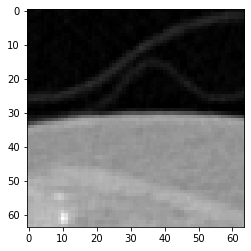

In [27]:
plt.imshow(test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:][0,:,:,32,0], cmap = "gray")

In [35]:
#model.fit(x=test_img, y=test_mask)
model.fit(x=test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:], y=test_mask[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:], epochs=20 )

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 1.3727e-04
Epoch 2/20
1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 272ms/step - loss: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 273ms/step - loss: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 273ms/step - loss: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 277ms/step - loss: nan
Epoch 11/20
1/1 [==============================] - 0s 273ms/step - loss: nan
Epoch 12/20
1/1 [==============================] - 0s 272ms/step - loss: nan
Epoch 13/20
1/1 [========